# Introduction to plot_lib

**IMPORTANT: Please, download the Notebook and run it locally to see the visualizations (from Github they cannot be seen)**

`plot_lib` is a library for quickly plotting 2D, 3D and 4D interactive images within Jupyter Notebooks, with the goals of being simple (call `plot(image)` and done! plots should look very good by default), versatile (can easily plot masks, points and boxes along with the image) and hackable (the code is very simple and any missing functinality can be easily added). However, this library is not very efficient, though I will be working to improve it in that regard.

First, we set up some code to allow the plots to appear side by side in the Notebook, occupying all available horizontal space. This should be the basic setup for every notebook. Please note that a better solution is on the works, but this works for now.

In [15]:
from IPython.display import display, HTML
br= lambda: print(' '*150)
CSS = """output_subarea { flex-direction: row; flex-wrap: wrap; }
         .output { flex-direction: row; flex-wrap: wrap; }
         .widget-hslider { width: auto !important} """
HTML('<style>{}</style>'.format(CSS))

Second, we must download some images to plot. We weill use a freely available CT image.

**Note:** this example requires downloading ~ 70Mb in image data (please, be patient, depeding on the server load it may take a while)

In [2]:
#Load all required libraries for the example
import SimpleITK as sitk
import pandas as pd
import numpy as np
import urllib.request
import tarfile
import os

#Set up all paths
data_path= os.path.join('./', 'EXAMPLE_DATA')
base_url= 'https://www.creatis.insa-lyon.fr/~srit/POPI'
dl_paths= ['Landmarks/00-Landmarks.pts', 'Masks/00Mask-MetaImage.tar', 
           'Images/MetaImage/00-MetaImage.tar']
mask_name, image_name, landmarks_name= '00-air-body-lungs.mhd', '00-P.mhd', '00-Landmarks.pts'

def download_and_unpack(url):
    print('Downloading and extracting: %s'%url, end='')
    if url.endswith('.tar'):
        stream = urllib.request.urlopen(url)
        file = tarfile.open(fileobj=stream, mode="r|*")
        file.extractall(path=data_path)
    else:
        urllib.request.urlretrieve(url, os.path.join(data_path, 
                                                     url.rsplit('/', 1)[-1]))
    print(' - Done!')
    
#Download all required files if directory does not exist already
if not os.path.exists(data_path):
    os.makedirs(data_path, exist_ok=True)
    for dl_path in dl_paths:
        download_and_unpack(os.path.join(base_url, dl_path).replace('\\', '/'))
else:
    print('Images already downloaded. To reload them, please delete: %s'%data_path)

Images already downloaded. To reload them, please delete: ./EXAMPLE_DATA


Then, we read them (using SimpleITK) and downscale them

In [3]:
def downscale_by_factor(image, factor=2):
    new_image= sitk.GetArrayFromImage(image)[::factor, ::factor, ::factor]
    new_image= sitk.GetImageFromArray(new_image)
    new_image.SetSpacing(np.array(image.GetSpacing())*factor)
    new_image.SetDirection(image.GetDirection())
    new_image.SetOrigin(image.GetOrigin())
    return new_image

In [4]:
#Read and downscale image, mask and landmarks
image= sitk.ReadImage(os.path.join(data_path, image_name))
image_d= downscale_by_factor(image)

mask= sitk.ReadImage(os.path.join(data_path, mask_name))
mask_d= downscale_by_factor(mask)

points= pd.read_csv(os.path.join(data_path, landmarks_name), index_col=False, 
                    delimiter='\t', skiprows=1, names=['x', 'y', 'z'])

For a first approach, we can try to plot them directly. The units in both axes are milimeters.

**NOTE:** If you do not see both images side by side, try reloading the very first cell of the Notebook, or try using the Notebook *outside* Jupyter Lab (which is known to cause some issues in this regard)

In [5]:
from plot_lib import plot

plot(image_d, title='Image')
plot(mask_d, title='Mask')

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

To break the flow behaviour (both plots appear side by side) use the function `br()`

In [6]:
plot(image_d, title='Image'); br()
plot(mask_d, title='Mask')

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

We can also plot an image directly given its path (this relies on SimpleITK to load the image)

In [7]:
path= os.path.join(data_path, image_name)
plot(path, title=path)

interactive(children=(IntSlider(value=70, continuous_update=False, description='z', max=140, style=SliderStyle…

For a second approach, we can plot the image, the mask and the points together. In such cases, the mask can be shown in one of two ways: only the edge (default) or as a color overlay (setting `plot_label_edge=False`)

Please note that the points must be provided in pixel coordinates, not in physical coordinates. If using SimpleITK, this can be easily achieved as shown below (even if the image was resampled, as is the case).

In [8]:
points_in_pixel_coordinates_d= [image_d.TransformPhysicalPointToContinuousIndex(p) for p in points.values]

plot(image_d, masks=[mask_d], points=points_in_pixel_coordinates_d)
plot(image_d, masks=[mask_d], points=points_in_pixel_coordinates_d, plot_label_edge=False)

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

We can simultaneously represent boxes (besides masks and points), and customize many aspects of the presentation.

Take a look at the `docstring` for plot (i.e.: `print(plot.__doc__)`) for more information.

In [9]:
points_in_pixel_coordinates= [image.TransformPhysicalPointToContinuousIndex(p) for p in points.values]
plot(image, 
     masks=[[mask, [2], ['tab:red'], ['Lungs']]] , 
     points=[[*list(p), 'o', 'default', '%  d: (%.0f, %.0f)'%(i, p[0], p[1])] 
             for i,p in enumerate(points_in_pixel_coordinates)],
     boxes= [ [100, 170, 100, 170, 70, 80, 'default', 'Example box'] ],
     scale=3, #Scale of the image itself
     dpi=200, #Scale of all plot matplotlib elements (e.g.: text sizes, ax sizes)
     z=57,    #Default z-slice
     hide_axis=True,
     center_crop=[400, 300, 200], #Get a center crop of size [x*y*z] (in mm)
    )

interactive(children=(IntSlider(value=57, continuous_update=False, description='z', style=SliderStyle(handle_c…

The libary works transparently with images provided as numpy arrays (as long as spacing is also provided)

In [10]:
image_np= sitk.GetArrayFromImage(image)
mask_np= sitk.GetArrayFromImage(mask)
plot(image_np, masks=[[mask_np, [2], ['tab:red']]], points=points_in_pixel_coordinates, 
     scale=1.5, dpi=150, title='Image & mask (numpy)', z=77,
     plot_label_edge=False, alpha=0.5, spacing=image.GetSpacing())
br(); print('Shape of image:', image_np.shape)

interactive(children=(IntSlider(value=77, continuous_update=False, description='z', max=140, style=SliderStyle…

                                                                                                                                                      
Shape of image: (141, 360, 482)


It also works with 2D images. Here, we will simulate a 2D image by taking a z slice from the original image

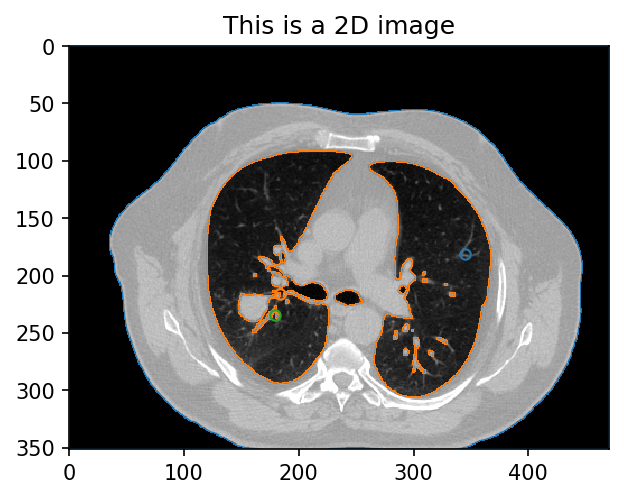

                                                                                                                                                      
Shape of image: (141, 360, 482)


In [11]:
z_slice= 77
plot(image_np[z_slice], masks=[mask_np[z_slice]], title='This is a 2D image', scale=1.5, dpi=150,
     points=[p for p in points_in_pixel_coordinates if p[-1] == z_slice], spacing=image.GetSpacing())
br(); print('Shape of image:', image_np.shape)

Finally, the library can also deal with images that have extra channels or a time component. For this example, we will create a fake time series from the original image by applying some transformations to its pixel intesities (just as an example)

In [12]:
from plot_lib import rescale_intensity

image_npr= rescale_intensity(sitk.GetArrayFromImage(image_d), thres=(0,100))
image_many_channels= np.stack([np.float_power(image_npr,i) for i in np.arange(0.3, 1.9, 0.3)], axis=-1)
print('Shape of image:', image_many_channels.shape)

Shape of image: (71, 180, 241, 6)


For a very first approach, we can use the parameter `ct` to select which channel to plot

In [13]:
for channel in range(image_many_channels.shape[-1]):
    plot(image_many_channels, ct=channel, title='Channel: %d'%channel, 
         spacing=image_d.GetSpacing(), masks=[mask_d])

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=35, description='z', max=70, style=SliderStyle(handle_color='lightblue')…

Alternatively, we can use the function `plot4` to add a second slider to the image that allows us to explore the channel / time dimension interactively. Please note that updating the c/t slider is very slow as of now.

In [14]:
from plot_lib import plot4
plot4(image_many_channels, spacing=image_d.GetSpacing(), masks=[mask_d])

interactive(children=(IntSlider(value=3, continuous_update=False, description='c/t', max=5, style=SliderStyle(…

There are a few more interesting functions that will not be covered for now, such as:

 * `plot_alpha`: Plots an image mixed with another given an alpha value. Useful for comparing registered images.
 * `plot_multi_mask`: Plots an image along with all the channels from its mask. Useful for dealing with multichannel masks.
 * `plot_channel_alpha`: Plots an overlay of any two channels of an image. Same as plot_alpha, but getting the images from channels.